In [1]:
from Swimmer import *
import numpy as np
import datetime 
plt.rc('text', usetex=True)
import matplotlib
matplotlib.rcParams.update({'font.size': 32})


## Initialization

In [2]:
T=1
R=1
a = 10*R
epsilons = np.linspace(0.1,5,50)*R

steps = 1000
nsteps = 1000
dt = T/steps

r0 = np.array([[0, 0, 0],
[0, 0, a],
[a*np.sqrt(8)/3, 0 , -a/3],
[-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
[-a*np.sqrt(8)/6, -a*np.sqrt(24)/6, -a/3]])


epsilon = 7
w = epsilon/T
closing  = a - np.arange(steps+1)*epsilon/steps
opening = a - epsilon + np.arange(steps+1)*epsilon/steps
opened = a *np.ones(steps+1)
closed = (a-epsilon)*np.ones(steps+1)

In [3]:
def saveCoordination(r,name): 
    text  = """#version 3.7; 
    global_settings { assumed_gamma 1.0 }
    

    camera {
    location  <20, 20, 20>
    right     x*image_width/image_height
    look_at   <0, 0, 0>
    angle 58
    }

    background { color rgb<1,1,1>*0.03 }


    light_source { <-20, 30, -25> color red 0.6 green 0.6 blue 0.6 }
    light_source { < 20, 30, -25> color red 0.6 green 0.6 blue 0.6 }
    
    #declare m = 1;
    union {

    union {
    sphere { m*<""" + str(r[0,0])+ ","+ str(r[0,1])+"," +str(r[0,2])+""">, 1 }        
    sphere {  m*<"""+str(r[1,0])+","+ str(r[1,1])+"," +str(r[1,2])+""">, 1 }
    sphere {  m*<"""+str(r[2,0])+","+ str(+r[2,1])+"," +str(r[2,2])+""">, 1 }
    sphere {  m*<""" +str(r[3,0])+","+ str(r[3,1])+"," +str(r[3,2])+""">, 1}
    sphere { m*<"""+str(r[4,0])+"," +str(r[4,1])+"," +str(r[4,2])+""">, 1 }    

        pigment { color rgb<0.8,0,0>  }
    finish { ambient 0.1 diffuse 0.7 phong 1 }
    }    
    union {
    cylinder { m*<"""+str(r[1,0])+"," +str(r[1,1])+","+ str(r[1,2])+">, <"+str(r[0,0])+","+ str(r[0,1])+"," +str(r[0,2])+""">, 0.5 }
    cylinder { m*<"""+str(r[2,0])+"," +str(r[2,1])+"," +str(r[2,2])+">, <"+str(r[0,0])+"," +str(r[0,1])+","+ str(r[0,2])+""">, 0.5}
    cylinder { m*<"""+str(r[3,0])+"," +str(r[3,1])+"," +str(r[3,2])+">, <"+str(r[0,0])+"," +str(r[0,1])+"," +str(r[0,2])+""">, 0.5 }
    cylinder {  m*<""" +str(r[4,0])+"," +str(r[4,1])+","+str(r[4,2])+">, <"+str(r[0,0])+","+str(r[0,1])+","+str(r[0,2])+""">, 0.5}

    pigment { color rgb<0.6,.2,.2>  }
    finish { ambient 0.1 diffuse 0.7 phong 1 }    
    }
    
    // rotate <0, 0, 0>
    }
    """
    f = open(f"./pov/{name}.pov", "a")
    f.write(text)
    f.close()

In [5]:
saveCoordination(rf2,"coor")

NameError: name 'rf2' is not defined

In [6]:
qounter = np.array([0])
np.save("q",qounter)
q = np.load("q.npy")
str(q[0])

'0'

In [4]:
@njit
def mul(a,b):
    ans = np.zeros((5,5,3,3))
    for i in range(5):
        for j in range(5):
            ans[i,j] = a @ b[i,j]
    return ans

def visualize(r,angles=(0,0)):
    ax = plt.figure().add_subplot(projection='3d')
    colors = ('r', 'g', 'b', 'k','y')
    ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)
    
    for j in range(0,5):
        ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
    
    ax.view_init(angles[0],angles[1])
    return ax


def getAngle(a,b):
    return (180/np.pi)*np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))



@njit
def getDistanceMatrix(A):   # dij = rj - ri
    tiledPoses = tile(A)
    distances = tiledPoses - tiledPoses.transpose((1,0,2))
    return distances



@njit
def tile(x):
    tiled = np.zeros((5,5,3))
    for i in range(5):
        tiled[i,:,:] = x
        
    return tiled


def getR0(ls):
    a1,a2,a3,a4 = ls
    
    R0 = [[0, 0, 0],
    [0, 0, a1],
    [a2*np.sqrt(8)/3, 0 , -a2/3],
    [-a3*np.sqrt(8)/6, a3*np.sqrt(24)/6 , -a3/3],
    [-a4*np.sqrt(8)/6, -a4*np.sqrt(24)/6, -a4/3]]
    
    return np.array(R0)




@njit
def tile2(x):
    tiled = np.zeros((5,5,3,3))
    for i in range(3):
        for j in range(3):
            tiled[:,:,i,j] = x
        
    return tiled


@njit
def getO(d,R):
    d2 = d**2    
    drNorm = np.sum(d2,axis=2)**0.5
            
    
    I5_5_3_3 = np.zeros((5,5,3,3))

    for i in range(5):
        for j in range(5):
            I5_5_3_3[i,j,:,:] = np.eye(3)


    c1 = d.reshape(5,5,3,1)
    c2 = c1.transpose(0,1,3,2)    
    B = np.multiply(c1,c2)    
    c3 = tile2(drNorm)

    O = R*(I5_5_3_3 + B/(c3**2))*0.75/c3 #*R/norm(l)

    for i in range(5):  #for i=j
        O[i,i,:,:] = np.eye(3)
        
    return mul(etas,O)

@njit
def getRR(r):
    rr0 = np.array([
    
    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]])
    
    
    rr1 = np.array([[0, -r[0,2] , r[0,1],  0, -r[1,2] , r[1,1],    0, -r[2,2] , r[2,1], 0, -r[3,2] , r[3,1]   ,0, -r[4,2] , r[4,1]],
    [r[0,2], 0 , -r[0,0],   r[1,2], 0 , -r[1,0],  r[2,2], 0 , -r[2,0],  r[3,2], 0 , -r[3,0],  r[4,2], 0 , -r[4,0]],
    [-r[0,1], r[0,0], 0 , -r[1,1], r[1,0], 0 , -r[2,1], r[2,0], 0 ,   -r[3,1], r[3,0], 0 ,  -r[4,1], r[4,0], 0 ]])
    
    


    
    return np.concatenate((rr0,rr1),axis=0)


@njit
def getOO(d):
    ##Check
    k2_3 = np.dot(d[1,0],d[1,0])*np.dot(d[2,0],d[2,0])/np.dot(d[1,0],d[2,0])
    k2_4 = np.dot(d[1,0],d[1,0])*np.dot(d[3,0],d[3,0])/np.dot(d[1,0],d[3,0])
    k2_5 = np.dot(d[1,0],d[1,0])*np.dot(d[4,0],d[4,0])/np.dot(d[1,0],d[4,0])
    k3_4 = np.dot(d[2,0],d[2,0])*np.dot(d[3,0],d[3,0])/np.dot(d[2,0],d[3,0])
    k3_5 = np.dot(d[2,0],d[2,0])*np.dot(d[4,0],d[4,0])/np.dot(d[2,0],d[4,0])

    p2_3 = np.dot(d[2,0],d[2,0])*d[0,1] - k2_3*d[0,2] 
    p2_4 = np.dot(d[3,0],d[3,0])*d[0,1] - k2_4*d[0,3] 
    p2_5 = np.dot(d[4,0],d[4,0])*d[0,1] - k2_5*d[0,4] 
    p3_4 = np.dot(d[3,0],d[3,0])*d[0,2] - k3_4*d[0,3] 
    p3_5 = np.dot(d[4,0],d[4,0])*d[0,2] - k3_5*d[0,4] 


    q2_3 = np.dot(d[1,0],d[1,0])*d[0,2] - k2_3*d[0,1] 
    q2_4 = np.dot(d[1,0],d[1,0])*d[0,3] - k2_4*d[0,1] 
    q2_5 = np.dot(d[1,0],d[1,0])*d[0,4] - k2_5*d[0,1] 
    q3_4 = np.dot(d[2,0],d[2,0])*d[0,3] - k3_4*d[0,2] 
    q3_5 = np.dot(d[2,0],d[2,0])*d[0,4] - k3_5*d[0,2] 
    
    
    OO = np.array([
        [d[1,0,0], d[1,0,1], d[1,0,2], -d[1,0,0], -d[1,0,1], -d[1,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [d[2,0,0], d[2,0,1], d[2,0,2], 0, 0, 0, -d[2,0,0], -d[2,0,1], -d[2,0,2], 0, 0, 0, 0, 0, 0,   ],   
    [d[3,0,0], d[3,0,1], d[3,0,2], 0, 0, 0, 0, 0, 0, -d[3,0,0], -d[3,0,1], -d[3,0,2], 0, 0, 0],
    [d[4,0,0], d[4,0,1], d[4,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0, -d[4,0,0], -d[4,0,1], -d[4,0,2]],
    
    [-p2_3[0] -q2_3[0], -p2_3[1] -q2_3[1], -p2_3[2] -q2_3[2],                p2_3[0], p2_3[1], p2_3[2], q2_3[0], q2_3[1], q2_3[2], 0, 0, 0, 0, 0, 0], #2_3,
    [-p2_4[0] -q2_4[0], -p2_4[1] -q2_4[1], -p2_4[2] -q2_4[2],                p2_4[0], p2_4[1], p2_4[2], 0, 0, 0, q2_4[0], q2_4[1], q2_4[2], 0, 0, 0],  #2_4,
    [-p2_5[0] -q2_5[0], -p2_5[1] -q2_5[1], -p2_5[2] -q2_5[2],                p2_5[0], p2_5[1], p2_5[2], 0, 0, 0, 0, 0, 0, q2_5[0], q2_5[1], q2_5[2]], #2_5
    [-p3_4[0] -q3_4[0], -p3_4[1] -q3_4[1], -p3_4[2] -q3_4[2],                0, 0, 0, p3_4[0], p3_4[1], p3_4[2], q3_4[0], q3_4[1], q3_4[2], 0, 0, 0],  #3_4
    [-p3_5[0] -q3_5[0], -p3_5[1] -q3_5[1], -p3_5[2] -q3_5[2],                0, 0, 0, p3_5[0], p3_5[1], p3_5[2], 0, 0, 0, q3_5[0], q3_5[1], q3_5[2]] #3_5
    
    ])
    
    return OO




@njit
def getC(l,u):
    lu = np.zeros(4)
    for i in range(4):
        lu[i]= (l[i]*u[i])
        
    
    return np.array([*list(lu), 0,0,0,0,0,0,0,0, 0,0,0])  

#  u -> u/steps maybe



def getV(r,l,u,R):
    d = getDistanceMatrix(r)

    O = getO(d,R)
    newO = np.zeros((15,15))
    for i in range(5):
        for j in range(5):
            newO[3*i:3*i+3,3*j:3*j+3] = O[i,j]
        
    rr= getRR(r)
    mm = np.linalg.inv(newO)


    NN = np.matmul(rr,mm)
    OO = getOO(d)
    AA = np.concatenate((OO,NN),axis=0)
    
    
    

    BB = getC(l,u)
    
    return np.linalg.solve(AA,BB)
        
     
        
def step(r,L,R):
    for t in range(1000):
        try:
            U = L[:,t+1]-L[:,t]
        except IndexError:
            U = L[:,t]-L[:,t-1]
            
        v = getV(r,L[:,t],U,R).reshape((5,3))
        
        r += v  ##########

        
        # q = np.load("q.npy")
        
        # # saveCoordination((ro @ r.T).T  + totalDelta,str(q[0]))

        # q +=1

        # np.save("q",q)

        
        
    return r  



def act(L,R):
    r = getR0(L[:,0])
    r_final = step(r.copy(),L,R)
    delta = list(r_final - r)[0]
    
    return r_final,delta,np.matmul(getE(r_final), np.linalg.inv(getE(r)))


def getE(r):
    e1 = ((r[1]-r[0])/np.linalg.norm((r[1]-r[0]))).reshape((3,1))
    e2 = ((r[2]-r[0])/np.linalg.norm((r[2]-r[0]))).reshape((3,1))
    e3 = ((r[3]-r[0])/np.linalg.norm((r[3]-r[0]))).reshape((3,1))
    
    return np.concatenate((e1,e2,e3),axis=1)





In [5]:
ro = np.eye(3)
totalDelta = np.zeros(3)

rf1,delta1,ro1 =  act(np.array([closing,opened,opened,opened]),R)
totalDelta += np.matmul(ro,delta1)
ro  = np.matmul(ro1,ro)

# print(np.linalg.norm(getDistanceMatrix(rf2),axis=2))

rf2,delta2,ro2 =  act(np.array([closed,closing,opened,opened]),R)
totalDelta += np.matmul(ro,delta2)
ro  = np.matmul(ro2,ro)
# print(np.linalg.norm(getDistanceMatrix(rf2),axis=2))


rf3,delta3,ro3=  act(np.array([closed,closed,closing,opened]),R)
totalDelta += np.matmul(ro,delta3)
ro  = np.matmul(ro3,ro)
# print(np.linalg.norm(getDistanceMatrix(rf3),axis=2))


rf4,delta4,ro4=  act(np.array([closed,closed,closed,closing]),R)
totalDelta += np.matmul(ro,delta4)
ro  = np.matmul(ro4,ro)

rf5,delta5,ro5=  act(np.array([opening,closed,closed,closed]),R)
totalDelta += np.matmul(ro,delta5)
ro  = np.matmul(ro5,ro)
# print(np.linalg.norm(getDistanceMatrix(rf4),axis=2))


rf6,delta6,ro6=  act(np.array([opened,opening,closed,closed]),R)
totalDelta += np.matmul(ro,delta6)
ro  = np.matmul(ro6,ro)
# print(np.linalg.norm(getDistanceMatrix(rf5),axis=2))


rf7,delta7,ro7 =  act(np.array([opened,opened,opening,closed]),R)
totalDelta += np.matmul(ro,delta7)
ro  = np.matmul(ro7,ro)
# print(np.linalg.norm(getDistanceMatrix(rf6),axis=2))

rf8,delta8,ro8 =  act(np.array([opened,opened,opened,opening]),R)
totalDelta += np.matmul(ro,delta8)
ro  = np.matmul(ro8,ro)



rf2 = (ro @ rf2.T).T
rf2 += delta1
ro = ro1 @ ro


rf3 = (ro @ rf3.T).T
rf3 += delta2
ro = ro2 @ ro


rf4 = (ro @ rf4.T).T
rf2 += delta3
ro = ro3 @ ro


rf5 = (ro @ rf5.T).T
rf5 += delta4
ro = ro4 @ ro


rf6 = (ro @ rf6.T).T
rf6 += delta5
ro = ro5 @ ro


rf7 = (ro @ rf7.T).T
rf7 += delta6
ro = ro6 @ ro


rf8 = (ro @ rf8.T).T
rf8 += delta7
ro = ro7 @ ro



In [7]:
totalDelta

array([-0.31520717, -0.2069999 , -0.39553252])

In [8]:
print((rf1-r0)[0])
print((rf2-rf1)[0])
print((rf3-rf2)[0])
print((rf4-rf3)[0])
print((rf5-rf4)[0])
print((rf6-rf5)[0])
print((rf7-rf6)[0])
print((rf8-rf7)[0])
print((rf8-r0)[0])

[-4.82552620e-19 -5.79123851e-18  1.19568336e+00]
[ 0.44726214  1.25931809 -1.27459877]
[-0.1007268  -0.22739781 -0.98635749]
[-0.96794729 -2.34038014  0.83701837]
[-0.38482505 -0.10625415 -1.67550911]
[-0.19561999  1.28394992  1.28294576]
[ 0.77215655 -0.8169616   1.57810997]
[ 1.54622842  0.90207397 -0.37618572]
[ 1.11652798 -0.04565173  0.58110638]


In [8]:
r0

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 10.        ],
       [ 9.42809042,  0.        , -3.33333333],
       [-4.71404521,  8.16496581, -3.33333333],
       [-4.71404521, -8.16496581, -3.33333333]])

In [9]:
getAngle(rf5[3] - rf5[0],rf5[4] - rf5[0])

109.47410806947732

In [6]:
def saveCoordination(r,name): 
    text  = """#version 3.7; 
    global_settings { assumed_gamma 1.0 }
    

    camera {
    location  <20, 20, 20>
    right     x*image_width/image_height
    look_at   <0, 0, 0>
    angle 58
    }

    background { color rgb<1,1,1>*0.03 }


    light_source { <-20, 30, -25> color red 0.6 green 0.6 blue 0.6 }
    light_source { < 20, 30, -25> color red 0.6 green 0.6 blue 0.6 }
    
    #declare m = 1;
    union {

    union {
    sphere { m*<""" + str(r[0,0])+ ","+ str(r[0,1])+"," +str(r[0,2])+""">, 1 }        
    sphere {  m*<"""+str(r[1,0])+","+ str(r[1,1])+"," +str(r[1,2])+""">, 1 }
    sphere {  m*<"""+str(r[2,0])+","+ str(+r[2,1])+"," +str(r[2,2])+""">, 1 }
    sphere {  m*<""" +str(r[3,0])+","+ str(r[3,1])+"," +str(r[3,2])+""">, 1}
    sphere { m*<"""+str(r[4,0])+"," +str(r[4,1])+"," +str(r[4,2])+""">, 1 }    

        pigment { color rgb<0.8,0,0>  }
    finish { ambient 0.1 diffuse 0.7 phong 1 }
    }    
    union {
    cylinder { m*<"""+str(r[1,0])+"," +str(r[1,1])+","+ str(r[1,2])+">, <"+str(r[0,0])+","+ str(r[0,1])+"," +str(r[0,2])+""">, 0.5 }
    cylinder { m*<"""+str(r[2,0])+"," +str(r[2,1])+"," +str(r[2,2])+">, <"+str(r[0,0])+"," +str(r[0,1])+","+ str(r[0,2])+""">, 0.5}
    cylinder { m*<"""+str(r[3,0])+"," +str(r[3,1])+"," +str(r[3,2])+">, <"+str(r[0,0])+"," +str(r[0,1])+"," +str(r[0,2])+""">, 0.5 }
    cylinder {  m*<""" +str(r[4,0])+"," +str(r[4,1])+","+str(r[4,2])+">, <"+str(r[0,0])+","+str(r[0,1])+","+str(r[0,2])+""">, 0.5}

    pigment { color rgb<0.6,.2,.2>  }
    finish { ambient 0.1 diffuse 0.7 phong 1 }    
    }
    
    // rotate <0, 0, 0>
    }
    """
    f = open(f"./pov/{name}.pov", "a")
    f.write(text)
    f.close()

In [29]:
saveCoordination(rf1,"r1")
saveCoordination(rf2,"r2")
saveCoordination(rf3,"r3")
saveCoordination(rf4,"r4")
saveCoordination(rf5,"r5")
saveCoordination(rf6,"r6")
saveCoordination(rf7,"r7")
saveCoordination(rf8,"r8")

In [7]:
colors = ('r', 'g', 'b', 'k','y')

In [ ]:
fig = plt.figure(figsize=(12,10))
# plt.title("illustrating the sample sequence")
plt.axis("off")
ax = fig.add_subplot(3,3,1,projection="3d")
ax.set_title("step 0")
r= r0

ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)

for j in range(0,5):
    ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
ax.view_init(0,0)



ax = fig.add_subplot(3,3,2,projection="3d")
ax.set_title("step 1")
r= rf1

ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)

for j in range(0,5):
    ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
ax.view_init(0,0)


ax = fig.add_subplot(3,3,3,projection="3d")
ax.set_title("step 2")
r= rf2

ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)

for j in range(0,5):
    ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
ax.view_init(0,0)

ax = fig.add_subplot(3,3,4,projection="3d")
ax.set_title("step 3")
r= rf3

ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)

for j in range(0,5):
    ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
ax.view_init(0,0)

ax = fig.add_subplot(3,3,5,projection="3d")
ax.set_title("step 4")
r= rf4

ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)

for j in range(0,5):
    ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
ax.view_init(0,0)

ax = fig.add_subplot(3,3,6,projection="3d")
ax.set_title("step 5")
r= rf5

ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)

for j in range(0,5):
    ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
ax.view_init(0,0)

ax = fig.add_subplot(3,3,7,projection="3d")
ax.set_title("step 6")
r= rf6

ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)

for j in range(0,5):
    ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
ax.view_init(0,0)



ax = fig.add_subplot(3,3,8,projection="3d")
ax.set_title("step 7")
r= rf7

ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)

for j in range(0,5):
    ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
ax.view_init(0,0)


ax = fig.add_subplot(3,3,9,projection="3d")
ax.set_title("step 8")
r= rf8

ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)

for j in range(0,5):
    ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
ax.view_init(0,0)



plt.savefig("2_1.png")
plt.show()


In [ ]:
plt.subplot(3,3,1)

p1 = visualize(r0)
plt.title("Illustrating a sequence:step 0")
plt.savefig("step0.png")

plt.subplot(3,3,2)

p1 = visualize(rf1)
plt.title("Illustrating a sequence:step 1")
plt.savefig("step0.png")

plt.subplot(3,3,3)

p2 = visualize(rf2)
plt.title("Illustrating a sequence:step 2")
plt.savefig("step1.png")

plt.subplot(3,3,4)

p3 = visualize(rf3)
plt.title("Illustrating a sequence:step 3")
plt.savefig("step2.png")

plt.subplot(3,3,5)

p4 = visualize(rf4)
plt.title("Illustrating a sequence:step 4")
plt.savefig("step3.png")

plt.subplot(3,3,6)

p5 = visualize(rf5)
plt.title("Illustrating a sequence:step 5")
plt.savefig("step4.png")

plt.subplot(3,3,7)


p6 = visualize(rf6)
plt.title("Illustrating a sequence:step 6")
plt.savefig("step5.png")

plt.subplot(3,3,8)

p6 = visualize(rf7)
plt.title("Illustrating a sequence:step 7")
plt.savefig("step5.png")

plt.subplot(3,3,9)

p6 = visualize(rf8)
plt.title("Illustrating a sequence:step 8")
plt.savefig("step5.png")

plt.show()


## Rotor

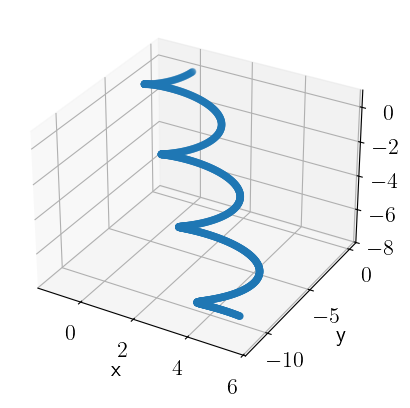

In [3]:
_,_,_,_,_,ax = getCircleSteps(10,3,1000)

In [5]:
#plt.title("Illustrating repeating a sequence with a=10, R=1, eps=3 for 1000 times")
plt.show(ax)

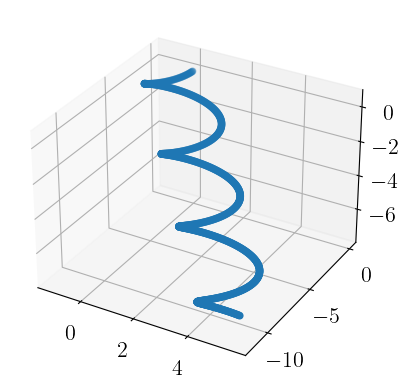

<Figure size 640x480 with 0 Axes>

In [ ]:

_,_,_,_,_,ax =  getCircleSteps(10,3,1000)
plt.savefig("2_2.png")



In [5]:
def getCircleSteps2(a,epsilon,rotorStep):
    # epsilon = 3
    R = 1 
    closing  = a - np.arange(steps+1)*epsilon/steps
    opening = a - epsilon + np.arange(steps+1)*epsilon/steps
    opened = a *np.ones(steps+1)
    closed = (a-epsilon)*np.ones(steps+1)

    totalRotation = np.eye(3)
    totalDelta = 0
    
    rf1,delta,Rotation=  act(np.array([closing,opened,opened,opened]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf2,delta,Rotation=  act(np.array([closed,closing,opened,opened]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf3,delta,Rotation=  act(np.array([closed,closed,closing,opened]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf4,delta,Rotation=  act(np.array([closed,closed,closed,closing]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf5,delta,Rotation=  act(np.array([opening,closed,closed,closed]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf6,delta,Rotation=  act(np.array([opened,opening,closed,closed]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf7,delta,Rotation=  act(np.array([opened,opened,opening,closed]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf8,delta,Rotation=  act(np.array([opened,opened,opened,opening]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)
    
    
    
    
    
    
    
    
    
    #rotorStep = 1000
    rotorR = np.array([0.,0.,0.])
    rotorRotation = np.eye(3)

    poses = np.zeros((rotorStep,3))
    for i in range(rotorStep):
        rotorR += np.matmul(rotorRotation,totalDelta)
        rotorRotation = np.matmul(totalRotation,rotorRotation)
        poses[i,:] = rotorR
        
        
    # ax = plt.figure().add_subplot(projection='3d')

    # ax.scatter(xs = poses[:,0],ys = poses[:,1], zs=poses[:,2])
    # plt.show()
        
        
    deltaSpringPerStep = (poses[-1]-poses[0])/rotorStep
    
    # plt.scatter(poses[:,0],poses[:,1])
    # plt.show()
    
    ys= poses[:,1] 
    maxes = np.logical_and((ys >= np.roll(ys,1)),(ys >= np.roll(ys,-1)))
    a1 = list(maxes).index(True,1)
    a2 = list(maxes).index(True,a1+1)

    circlingSteps = a2 -a1
    rotorR = np.array([0.,0.,0.])
    rotorRotation = np.eye(3)

    OneCirclePoses = np.zeros((circlingSteps,3))
    for i in range(circlingSteps):
        rotorR += np.matmul(rotorRotation,totalDelta)
        rotorRotation = np.matmul(totalRotation,rotorRotation)
        OneCirclePoses[i,:] = rotorR
    
    # plt.scatter(poses[:,0],poses[:,1])
    # plt.show()

    image = OneCirclePoses - ((OneCirclePoses[-1]-OneCirclePoses[0])/circlingSteps)*np.arange(circlingSteps).reshape((circlingSteps,1))
    meanPoing = np.mean(image,axis=0)

    # ax = plt.figure().add_subplot(projection='3d')
    # ax.scatter(xs = image[:,0],ys = image[:,1], zs=image[:,2])
    # ax.scatter(np.mean(image[:,0]),np.mean(image[:,1]),np.mean(image[:,2]))
    # ax.scatter(meanPoing[0],meanPoing[1],meanPoing[2])
    
    # plt.show()

   
    return *deltaSpringPerStep,circlingSteps,np.mean(np.linalg.norm(image - meanPoing,axis=1))



In [ ]:
getCircleSteps2(As[0],Eps[0]*As[0],10000)

In [ ]:
RotorAandEpsData = np.zeros((20,20,5))
As = [a for a in range(10, 30)]
Eps = [eps for eps in np.arange(20,40,1)/80]

for i in range(20):
    for j in range(20):
        print(i,j)
        RotorAandEpsData[i,j] = getCircleSteps2(As[i],Eps[j]*As[i],10000)

In [6]:
np.save("RotorAandEpsData.npy",RotorAandEpsData)

In [3]:
As = [a for a in range(10, 30)]
Eps = [eps for eps in np.arange(20,40,1)/80]
RotorAandEpsData = np.load("RotorAandEpsData.npy")

In [4]:
ylables = ["$n_r$", "$\\rho$","$v$","$h$"]
ylables_log = ["$\ln(n_r)$", "$\ln(\\rho)$","$\ln(v)$","$\ln(h)$"]

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_33703/255656071.py:2: SyntaxWarning: invalid escape sequence '\l'
  ylables_log = ["$\ln(n_r)$", "$\ln(\\rho)$","$\ln(v)$","$\ln(h)$"]
/tmp/ipykernel_33703/255656071.py:2: SyntaxWarning: invalid escape sequence '\l'
  ylables_log = ["$\ln(n_r)$", "$\ln(\\rho)$","$\ln(v)$","$\ln(h)$"]
/tmp/ipykernel_33703/255656071.py:2: SyntaxWarning: invalid escape sequence '\l'
  ylables_log = ["$\ln(n_r)$", "$\ln(\\rho)$","$\ln(v)$","$\ln(h)$"]
/tmp/ipykernel_33703/255656071.py:2: SyntaxWarning: invalid escape sequence '\l'
  ylables_log = ["$\ln(n_r)$", "$\ln(\\rho)$","$\ln(v)$","$\ln(h)$"]


In [22]:

# ylables = ["$ \delta x$","$\delta y$","$\delta z$", "$circling$ $Steps$", "$\\rho$","$displacement$","$pitch$"]
# ylables_log = ["$\ln(\delta x)$","$\ln(\delta y)$","$\ln(\delta z)$", "$\ln(circling$ $Steps)$", "$\ln(\\rho)$","$\ln(displacement)$","$\ln(pitch)$"]

In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [6]:
displacement = np.linalg.norm(RotorAandEpsData[:,:,:3],axis=2)

In [7]:
pitch =  displacement * RotorAandEpsData[:,:,3] 

In [8]:
from matplotlib import ticker 

In [ ]:
# hieghts = [0.04,0.015,0.013,600,1.3]



# j = 3
# fig, ax = plt.subplots(1)
# ins = ax.inset_axes([0.7,0.7,0.2,0.2])
# for i in range(20):
#     ax.plot(As,RotorAandEpsData[:,i,j])
#     # ins.locator_params(axis='both', nbins=2) 
#     ins.plot(np.log(As), np.log(np.abs(RotorAandEpsData[:,i,j])))
#     # ins.xaxis.set_ticklabels([])
#     # ins.set_xticks([10,30])

#     # ins.xaxis.set_major_locator(ticker.NullLocator())
#     # ins.xaxis.set_major_locator(ticker.LogLocator(base=np.exp(1), numticks=2))
#     # ins.xaxis.set_visible(True)

#     # # print(ins.get_xticks())
#     # ins.set_xticks([])

#     # ins.set_xticks([ins.get_xticks()[0], ins.get_xticks()[-1]])
#     # ins.set_yticks([ins.get_yticks()[0], ins.get_yticks()[-1]])

#     # print(ins.get_yticks())

# plt.scatter(10,600,c= "white")
# plt.xlabel("$L$")
# plt.ylabel(ylables[j-3])



# plt.savefig("2_" + str(j) +".png", bbox_inches="tight")
        
# plt.show()


In [10]:
matplotlib.rcParams.update({'font.size': 34})

<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_33703/3690493668.py:9: SyntaxWarning: invalid escape sequence '\e'
  axs[ 0].text(19.5, 4.5, "$\epsilon$", fontsize=fontsize)
/tmp/ipykernel_33703/3690493668.py:18: SyntaxWarning: invalid escape sequence '\e'
  axs[ 1].text(19.5, 1.45, "$\epsilon$", fontsize=fontsize)
/tmp/ipykernel_33703/3690493668.py:28: SyntaxWarning: invalid escape sequence '\e'
  axs[ 2].set_xlabel("$\epsilon$")
/tmp/ipykernel_33703/3690493668.py:37: SyntaxWarning: invalid escape sequence '\e'
  axs[ 3].set_xlabel("$\epsilon$")


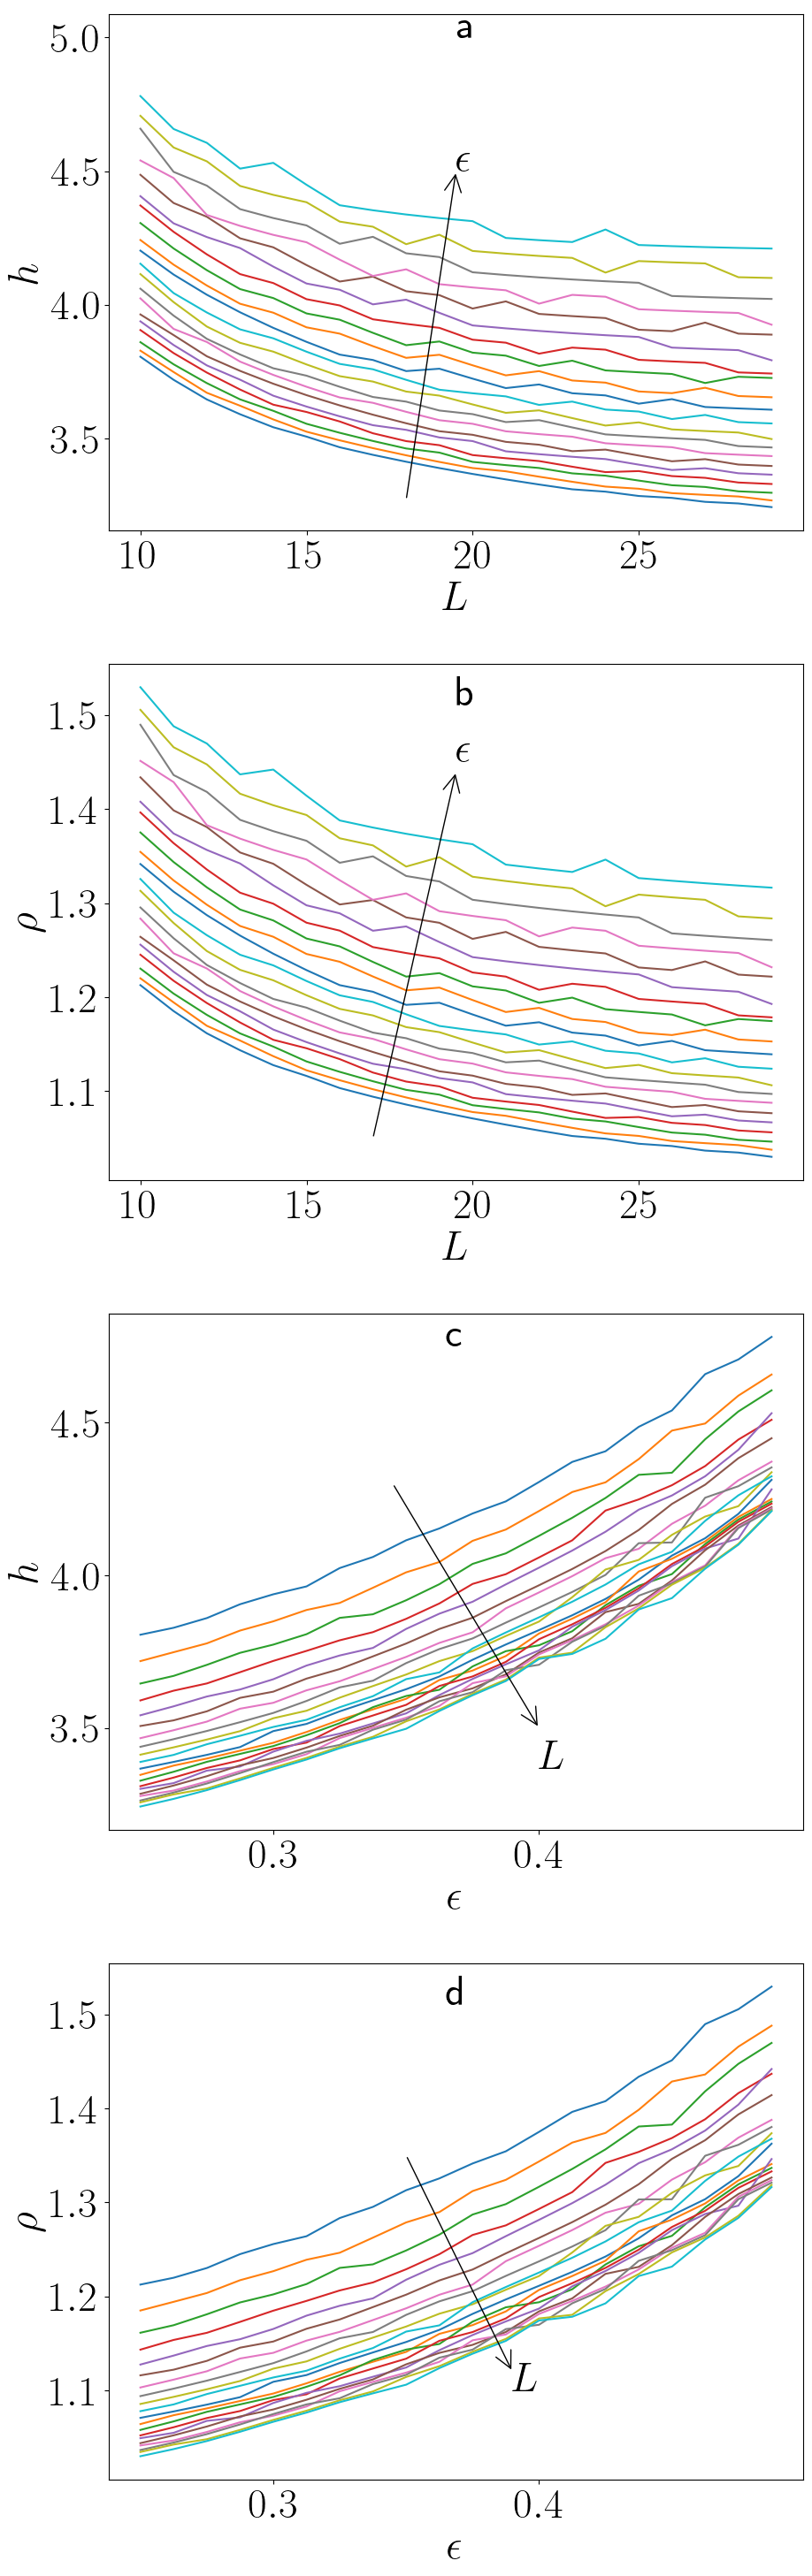

In [11]:
fontsize = 34
fig, axs = plt.subplots(4, 1, figsize=(10, 30))

# First plot
for i in range(20):
    axs[0].plot(As, pitch[:, i])
axs[ 0].scatter(10, 5, c="white")
axs[ 0].annotate("", xytext=(18, 3.27), xy=(19.5, 4.5), arrowprops=dict(arrowstyle="->"))
axs[ 0].text(19.5, 4.5, "$\epsilon$", fontsize=fontsize)
axs[ 0].set_xlabel("$L$")
axs[ 0].set_ylabel(ylables[3])
axs[ 0].text(19.5, 5, "a", fontsize=fontsize)

# Second plot
for i in range(20):
    axs[1].plot(As, RotorAandEpsData[:, i, 4])
axs[1].annotate("", xytext=(17, 1.05), xy=(19.5, 1.44), arrowprops=dict(arrowstyle="->"))
axs[ 1].text(19.5, 1.45, "$\epsilon$", fontsize=fontsize)
axs[ 1].set_xlabel("$L$")
axs[ 1].set_ylabel(ylables[1])
axs[ 1].text(19.5, 1.51, "b", fontsize=fontsize)

# Third plot
for i in range(20):
    axs[ 2].plot(Eps, pitch[i, :])
axs[ 2].annotate("", xytext=(0.345, 4.3), xy=(0.4, 3.5), arrowprops=dict(arrowstyle="->"))
axs[ 2].text(0.405, 3.4, "$L$", fontsize=fontsize, ha='center', va='center', rotation=0)
axs[ 2].set_xlabel("$\epsilon$")
axs[ 2].set_ylabel(ylables[3])
axs[ 2].text(0.365, 4.75, "c", fontsize=fontsize)

# Fourth plot
for i in range(20):
    axs[ 3].plot(Eps, RotorAandEpsData[i, :, 4])
axs[ 3].annotate("", xytext=(0.35, 1.35), xy=(0.39, 1.12), arrowprops=dict(arrowstyle="->"))
axs[ 3].text(0.39, 1.1, "$L$", fontsize=fontsize, color="black")
axs[ 3].set_xlabel("$\epsilon$")
axs[ 3].set_ylabel(ylables[1])
axs[ 3].text(0.365, 1.51, "d", fontsize=fontsize)

plt.tight_layout()
plt.savefig("merged_plots.png", bbox_inches="tight")
plt.show()

In [95]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # First plot
# for i in range(20):
#     axs[0, 0].plot(As, pitch[:, i])
# axs[0, 0].scatter(10, 5, c="white")
# axs[0, 0].annotate("", xytext=(18, 3.27), xy=(19.5, 4.5), arrowprops=dict(arrowstyle="->"))
# axs[0, 0].text(19.5, 4.5, "$\epsilon$", fontsize=16)
# axs[0, 0].set_xlabel("$L$")
# axs[0, 0].set_ylabel(ylables[3])

# # Second plot
# for i in range(20):
#     axs[0, 1].plot(As, RotorAandEpsData[:, i, 4])
# axs[0, 1].annotate("", xytext=(17, 1.05), xy=(19.5, 1.44), arrowprops=dict(arrowstyle="->"))
# axs[0, 1].text(19.5, 1.45, "$\epsilon$", fontsize=16)
# axs[0, 1].set_xlabel("$L$")
# axs[0, 1].set_ylabel(ylables[1])

# # Third plot
# for i in range(20):
#     axs[1, 0].plot(Eps, pitch[i, :])
# axs[1, 0].annotate("", xytext=(0.345, 4.3), xy=(0.4, 3.5), arrowprops=dict(arrowstyle="->"))
# axs[1, 0].text(0.405, 3.4, "$L$", fontsize=14, ha='center', va='center', rotation=0)
# axs[1, 0].set_xlabel("$\epsilon$")
# axs[1, 0].set_ylabel(ylables[3])

# # Fourth plot
# for i in range(20):
#     axs[1, 1].plot(Eps, RotorAandEpsData[i, :, 4])
# axs[1, 1].annotate("", xytext=(0.35, 1.35), xy=(0.39, 1.12), arrowprops=dict(arrowstyle="->"))
# axs[1, 1].text(0.39, 1.1, "$L$", fontsize=14, color="black")
# axs[1, 1].set_xlabel("$\epsilon$")
# axs[1, 1].set_ylabel(ylables[1])

# plt.tight_layout()
# plt.savefig("merged_plots.png", bbox_inches="tight")
# plt.show()



In [100]:
n_r = RotorAandEpsData[:,:,3]
n_r.shape

v = (displacement/n_r)



n_r = RotorAandEpsData[:,:,3]
n_r.shape

v = (displacement/n_r)

In [99]:
# fig, ax = plt.subplots(1)
# ins = ax.inset_axes([0.7,0.7,0.2,0.2])
# for i in range(20):
#     ax.plot(As,v[:,i])
#     ins.plot(np.log(As), np.log(np.abs(v[:,i])))
#     # ins.set_xticks([])
#     # ins.set_yticks([])

# plt.scatter(10,0.0011,c= "white")

# plt.xlabel("$L$")
# plt.ylabel(ylables[2])

# plt.savefig("2_8.png", bbox_inches="tight")

# plt.show()








<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:69: SyntaxWarning: invalid escape sequence '\e'
<>:99: SyntaxWarning: invalid escape sequence '\e'
<>:116: SyntaxWarning: invalid escape sequence '\e'
<>:140: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:69: SyntaxWarning: invalid escape sequence '\e'
<>:99: SyntaxWarning: invalid escape sequence '\e'
<>:116: SyntaxWarning: invalid escape sequence '\e'
<>:140: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_56796/2852388906.py:15: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\epsilon$")
/tmp/ipykernel_56796/2852388906.py:39: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\epsilon$")
/tmp/ipykernel_56796/2852388906.py:69: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\epsilon^-2$")
/tmp/ipykernel_56796/2852388906.py:99: SyntaxWarnin

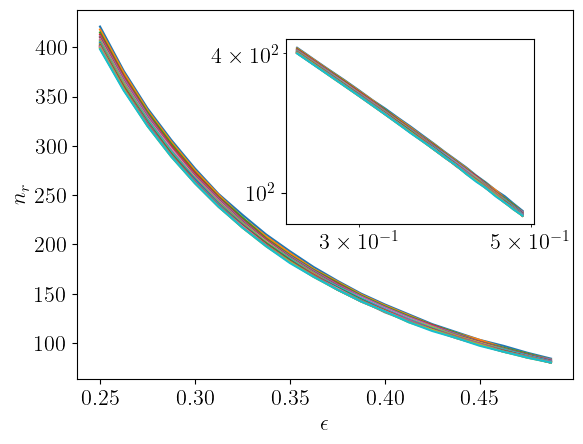

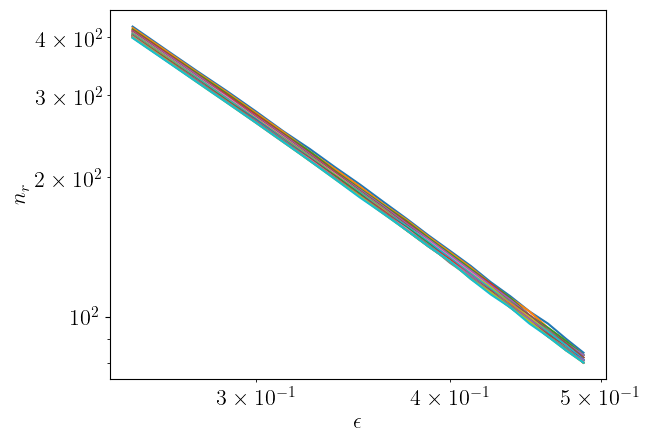

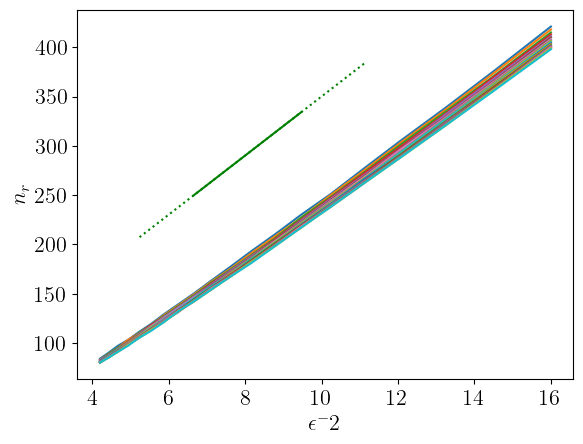

-2.41151684932793


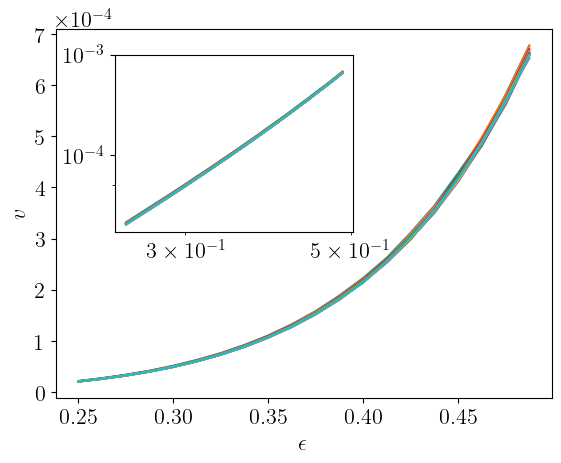

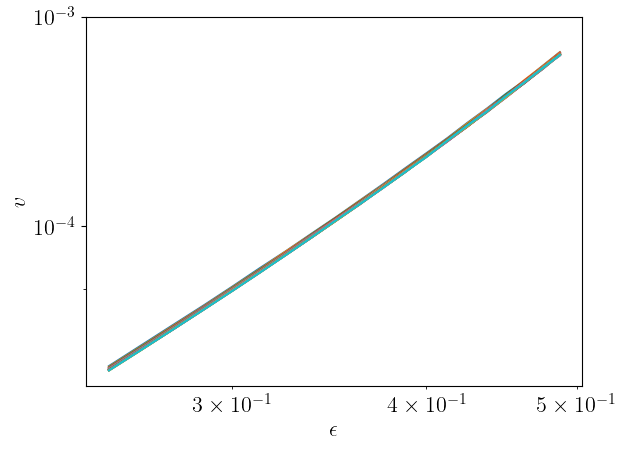

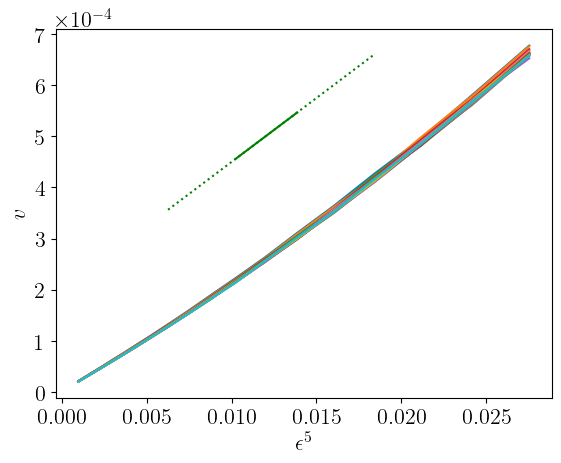

5.16341751594646


In [258]:


# plt.Figure(figsize=(20,20))
# plt.subplots(tight_layout=True)
hieghts = [0.2,0.7,0.7,0.7,0.2]
j = 3 
fig, ax = plt.subplots(1)
ins = ax.inset_axes([0.42,0.42,0.5,0.5])
for i in range(20):
    ax.plot(Eps,RotorAandEpsData[i,:,j])
    ins.loglog(Eps,np.abs(RotorAandEpsData[i,:,j]))
    ins.set_xticks([0.3,0.5],minor=True)
    ins.set_yticks([100,400],minor=True)



plt.xlabel("$\epsilon$")
plt.ylabel(ylables[j-3])

plt.savefig("n_r_vs_eps.png", bbox_inches="tight")
plt.show()





j = 3 
fig, ax = plt.subplots(1)
for i in range(20):
    ax.loglog(Eps,RotorAandEpsData[i,:,j])

    # ins.set_yticks([])

# from matplotlib.ticker import ScalarFormatter
# formatter = ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# formatter.set_powerlimits((-1, 1))
# ax.xaxis.set_major_formatter(formatter)
# ax.yaxis.set_major_formatter(formatter)

plt.xlabel("$\epsilon$")
plt.ylabel(ylables[j-3])

plt.savefig("n_r_vs_eps_loglog.png", bbox_inches="tight")
plt.show()






j = 3 
fig, ax = plt.subplots(1)
for i in range(20):
    ax.plot(np.power(Eps,-2),RotorAandEpsData[i,:,j])

    # ins.set_yticks([])

# from matplotlib.ticker import ScalarFormatter
# formatter = ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# formatter.set_powerlimits((0, 0))
# ax.xaxis.set_major_formatter(formatter)
# ax.yaxis.set_major_formatter(formatter)




ax.plot(np.power(Eps,-2)[4:16],50+30*np.power(Eps,-2)[4:16], c = "g" , linestyle='dotted')
ax.plot(np.power(Eps,-2)[6:12],50+30*np.power(Eps,-2)[6:12], c = "g")
plt.xlabel("$\epsilon^-2$")
plt.ylabel(ylables[j-3])
plt.savefig("n_r_vs_eps-2.png", bbox_inches="tight")
plt.show()
slope = scipy.stats.linregress(np.log(Eps),np.log(np.abs(RotorAandEpsData[0,:,j])))[0]
print(slope)




fig, ax = plt.subplots(1)
ins = ax.inset_axes([0.12,0.45,0.48,0.48])
for i in range(20):
    ax.plot(Eps,v[i,:])
    ins.loglog(Eps,np.abs(v[i,:]))
    ins.set_xticks([0.3,0.5],minor=True)
    ins.set_yticks([5e-5,1e-3],minor=True)


# ax.annotate("", xytext=(0.44, 0.0005), xy=(0.47, 0.0004), arrowprops=dict(arrowstyle="->"))
# ax.text(0.39, 1.1, "$L$", fontsize=14, color="black")


from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

plt.xlabel("$\epsilon$")
plt.ylabel(ylables[2])
plt.savefig("v_vs_eps.png", bbox_inches="tight")

plt.show()



fig, ax = plt.subplots(1)
for i in range(20):
    ax.loglog(Eps,v[i,:])

    # ins.set_yticks([])


ax.set_yticks([5e-5,1e-3],minor=True)

plt.xlabel("$\epsilon$")
plt.ylabel(ylables[2])
plt.savefig("v_vs_eps_loglog.png", bbox_inches="tight")

plt.show()





fig, ax = plt.subplots(1)
for i in range(20):
    ax.plot(np.power(Eps,5),v[i,:])
    # ins.set_yticks([])


# ax.set_yticks([0,1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4],minor=True)
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

plt.xlabel("$\epsilon^5$")
plt.ylabel(ylables[2])


ax.plot(np.power(Eps,5)[9:17],0.0002+0.025*np.power(Eps,5)[9:17], c = "g" , linestyle='dotted')
ax.plot(np.power(Eps,5)[12:15],0.0002+0.025*np.power(Eps,5)[12:15], c = "g")



plt.savefig("v_vs_eps5.png", bbox_inches="tight")

plt.show()

slope = scipy.stats.linregress(np.log(Eps),np.log(np.abs(v[0,:])))[0]
print(slope)


